#### Classify icebergs and ships on the SAR image

In [1]:
import os
import numpy as np 
import pandas as pd 
from os.path import join
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
from utils import data_split, model_history_plot, dB2natural, lee_filter

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

# import sys
# sys.path.append('.../GitHub/sar_ship_detect/scripts')

In [2]:
# Define path to the data
# PATH = r'C:/Users/arman/Documents/GitHub/sar_ship_detect'
PATH = '/home/manvel/GitHub/sar_ship_detect/'
#data_path = join(os. getcwd(), '..','data', 'Iceberg-classifier-challenge')
DATA_PATH = join(PATH, 'data/Iceberg-classifier-challenge')
OUT_PATH = join(PATH, 'model_weights')

In [3]:
#Load the data.
train = pd.read_json(join(DATA_PATH, 'train/train.json'))
#test = pd.read_json(join(DATA_PATH, 'test/test.json')) # test doesn't include the ship class data

In [4]:
print(train.columns)
print(train.shape)
print('0:',train.groupby('is_iceberg').size())

Index(['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg'], dtype='object')
(1604, 5)
0: is_iceberg
0    851
1    753
dtype: int64


### Intro about the Data.

**This primary code was found in this [Kaggle](https://www.kaggle.com/manvelkhudinyan/keras-model-for-beginners-0-210-on-lb-eda-r-d/edit) notebook**

**NOTE**: `not all the modifications here are mentioned, so you should find youeself if needed`

Sentinet -1 sat is at about 680 Km above earth. Sending pulses of signals at a particular angle of incidence and then recoding it back. Basically those reflected signals are called backscatter. The data we have been given is backscatter coefficient which is the conventional form of backscatter coefficient given by:

$ σo (dB) = βo (dB) + 10log10 [ sin(ip) / sin (ic)] $

where
1. ip=is angle of incidence for a particular pixel
2. 'ic' is angle of incidence for center of the image
3. K =constant.

We have been given $σo$ directly in the data. 
#### Now coming to the features of **σo** (sigma naught)\
Basically σo varies with the surface on which the signal is scattered from. For example, for a particular angle of incidence, it varies like:
*             WATER...........           SETTLEMENTS........           AGRICULTURE...........          BARREN........

1.**HH:**     -27.001   ................                     2.70252       .................                -12.7952        ................    -17.25790909

2.**HV:**      -28.035      ................            -20.2665             ..................          -21.4471       .................     -20.019

As you can see, the HH component varies a lot but HV doesn't.
**I don't have the data for scatter from ship, but being a metal object, it should vary differently as compared to ice object.**

Now coming to features, for the purpose of this demo code, all two bands were included and taking avg of them as 3rd channel to create a 3-channel RGB equivalent. 

### Data preparation

#### The band of angle has missing values
needs to be filled

The dataset explorative analysis show that a single incidence angle is presented for each ship chip. Thus, we can recover the image whole images with that given value in order to process in the model as another band for training.

As the incidence angle range for IW scanning mode (Interferometric Wide Swath) alters in the range of *29°-46°*, we can replace the missing incidence angles with **36.0°** (approximate average). More information on the Sentinel 1 IW mode can be found [here](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/acquisition-modes/interferometric-wide-swath)

Also, some articles state the importance of ratio of **Dual-Polarization incoheent** channels for object detection on sea. Hence we calculate also **HH/HV ratio** as anothee band

In [5]:
#imputer = SimpleImputer()
# simply replace all the 'na' values with a fixed value
train = train.replace({"inc_angle": 'na'}, 36.0)
# recover the image size for incidence angle band
train["inc_angle"] = train["inc_angle"].apply(lambda x: [x]*len(train["band_1"][0]))

In [6]:
# modify the data preprocessing
#Create 3 bands having HH, HV and incidence angle
HH = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
HV = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
angle = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["inc_angle"]])
Ratio = HH/HV 

# let's transform the backscatter intensity from dB into natural DN values
HH_natural = dB2natural(HH)
HV_natural = dB2natural(HV)
Ratio_natural = HH_natural/HV_natural

# apply Lee filter on the Natural values
HH_natural_lee = np.array([lee_filter(image, 4) for image in HH_natural])
HV_natural_lee = np.array([lee_filter(image, 4) for image in HV_natural])
Ratio_natural_lee = HH_natural_lee/HV_natural_lee

# data = np.concatenate([HH[:, :, :, np.newaxis], HV[:, :, :, np.newaxis],
#                           Ratio[:, :, :, np.newaxis]], axis=-1)

data = np.concatenate([HH_natural_lee[:, :, :, np.newaxis], HV_natural_lee[:, :, :, np.newaxis],
                          Ratio_natural_lee[:, :, :, np.newaxis]], axis=-1)

target = train['is_iceberg']

## original
`a fancy way of visualization which takes lots of RAM memory -> better not to run for the main analysis`

In [7]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(HH[12,:,:], 'iceberg - DB')

In [8]:
plotmy3d(HH[14,:,:], 'Ship - DB')

In [9]:
plotmy3d(HH_natural[14,:,:], 'Ship - natural values')

In [10]:
plotmy3d(HH_natural_lee[14,:,:], 'Ship - Lee filtered')

In [7]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, TensorBoard, EarlyStopping
from keras.metrics import binary_accuracy

Using TensorFlow backend.


In [18]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

#file_path = ".model_weights_inc_angle_as_band.hdf5"
weigth_path = join(OUT_PATH, ".Ice_HH_HV_Ratio_Lee_filter.hdf5")
callbacks = get_callbacks(filepath=weigth_path, patience=7)

# logdir = os.path.join('.\\Graph')

# tensorboard = [TensorBoard(log_dir=logdir, histogram_freq=1, profile_batch = 100000000,
#                           write_graph=True, write_images=True)]

## Data split

In [28]:
X_train, X_valid, X_test, y_train, y_valid, y_test = data_split(data, target, 
                                                                train_size=0.9, valid_size=0.35, scale='StandardScaler')

data split: 
Train: 	   937 
Validation: 506 
Test: 	    161


In [29]:
#Without denoising, core features.
gmodel=getModel()
history = gmodel.fit(X_train, y_train,
          batch_size=24,
          epochs=50, #50
          verbose=1,
          validation_data=(X_valid, y_valid),
          #callbacks=tensorboard)
          callbacks=callbacks)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

##### Core Model - without Augmentation

In [30]:
# model validation evaluation
gmodel.load_weights(weigth_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

506/506 [==============================] - 2s 3ms/step
Test loss: 0.19096955892596792
Test accuracy: 0.9150197505950928


#### Prediction

In [31]:
# model test evaluation
score = gmodel.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

161/161 [==============================] - 1s 3ms/step
Test loss: 0.3066521096386524
Test accuracy: 0.9006211161613464


#### Plot training history

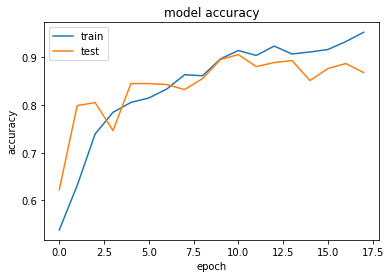

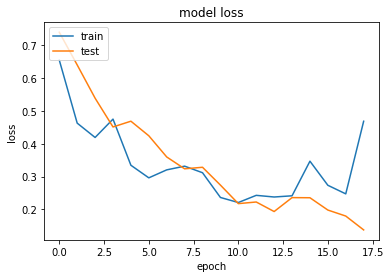

In [13]:
model_history_plot(history, save=False)

## Data Augmentation

This experinents with training data augmentation **did not** bring any improvements to our model.

### Data Preprocessing
**NOTE:** In case of loading data as `.jpeg` or `.png` from a directory use the code below

**TODO:** impement image saver with `.jpeg` or `.png`. Currently saves as `.npy` files

shutil.rmtree(out_train_iceberg)
shutil.rmtree(out_train_ship)
shutil.rmtree(out_val_iceberg)
shutil.rmtree(out_val_ship)

#Save data in a directory for loading by "flow_from_directory"
import glob
import shutil
import rasterio as rio

out_train_iceberg = glob.glob(join(DATA_PATH,"dat2augment/train/iceberg"))[0]
out_train_ship = glob.glob(join(DATA_PATH,"dat2augment/train/ship"))[0]
out_val_iceberg = glob.glob(join(DATA_PATH,"dat2augment/val/iceberg"))[0]
out_val_ship = glob.glob(join(DATA_PATH,"dat2augment/val/ship"))[0]

for im in range(y_train.size):
    im_class = y_train.iloc[im]
    
    if im_class == 0:
        with open(f'{out_train_iceberg}/im{im}.npy', 'wb') as f:
            np.save(f, X_train[im,:,:,:])
    if im_class == 1:
        with open(f'{out_train_ship}/im{im}.npy', 'wb') as f:
            np.save(f, X_train[im,:,:,:])

            
for im in range(y_valid.size):
    im_class = y_valid.iloc[im]
    
    if im_class == 0:
        with open(f'{out_val_iceberg}/im{im}.npy', 'wb') as f:
            np.save(f, X_valid[im,:,:,:])
    if im_class == 1:
        with open(f'{out_val_ship}/im{im}.npy', 'wb') as f:
            np.save(f, X_valid[im,:,:,:])

##### Core Model - with Augmentation

**Note:** we apply augmentation only on the training data in order to keep the validation dataset in original way to be compatible with test data for further details you can have a look on this blopost [here](https://medium.com/swlh/keras-imagedatagenerators-flow-methods-and-when-to-use-them-b9314489d591)

#set up augmentation params for ImageDataGenerator
data_generator_with_aug = ImageDataGenerator(preprocessing_function=None,
                                   fill_mode='reflect',
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   #rotation_range=45)
                                   #width_shift_range = 0.2,
                                   #height_shift_range = 0.2)

train_generator = data_generator_with_aug.flow(
                                X_train, y_train,
                                batch_size=24,
                                shuffle=True)

#call the model and run wirh augmentated training data
aug_model=getModel()
aug_history = aug_model.fit_generator(
        generator=train_generator,
        steps_per_epoch=42,
        epochs=50,
        validation_data=(X_valid, y_valid),
        verbose=1,
        callbacks=callbacks)

#model validation evaluation
aug_model.load_weights(weigth_path)
score = aug_model.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#### Prediction

#model test evaluation
score = aug_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model_history_plot(aug_history, save=False)